In [1]:
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, devices, default_backend
from tqdm import tqdm
from timeit import timeit
from functools import partial

In [2]:
import jax

# List all devices JAX can see
available_devices = jax.devices()
print(f"Available devices: {available_devices}")

# Get the default device JAX will use
default_device = jax.default_backend()
print(f"Default backend: {default_device}")


Available devices: [CudaDevice(id=0)]
Default backend: gpu


In [3]:
cpu_device = devices('cpu')[0]
gpu_device = devices('gpu')[0]
print(cpu_device)
print(gpu_device)

TFRT_CPU_0
cuda:0


In [ ]:
vector_a = np.arange(1, 4)
matrix_a = np.kron(vector_a, np.arange(1, 4).reshape(3, 1))

matrix_b = matrix_a + 1
#print(matrix_a)
#print(matrix_b)

resulting_matrix = matrix_a @ matrix_b
#print(resulting_matrix)

N = 1000
jax_vector_a = jnp.arange(1, 4).reshape(3, 1)
jax_matrix_a = jnp.kron(vector_a, jnp.arange(1, 4)).reshape(3, 3)
jax_matrix_b = jnp.kron(vector_a, jnp.ones(N)).reshape(vector_a.size, N)
jax_tensor_a = jnp.broadcast_to(jax_matrix_a, (N,)+(jax_matrix_a.shape))
#print(jnp.shape(jax_tensor_a))
#jax_matrix_b = jnp.sum(jnp.kron(vector_a, jnp.ones(N,)).reshape(3, N), 1)
#print(jax_matrix_b)

def vectorized_matrix_multiplication(matrix_input_1, vector_input_2):
    multiplied_result = jnp.matmul(matrix_input_1, vector_input_2)

    return multiplied_result

print(vectorized_matrix_multiplication(jax_tensor_a[0, :, :], jax_matrix_b[:, 0]))

batched_matrix_multiplication = jit(vmap(vectorized_matrix_multiplication, in_axes=(0, 1), out_axes=1))

expressions = jax.make_jaxpr(batched_matrix_multiplication)
print(expressions)

parallelized_tensor = batched_matrix_multiplication(jax_tensor_a, jax_matrix_b)

normal_tensor_jit = vectorized_matrix_multiplication
def naive_matrix_multiplication(timevector):
    for value in range(N):
        output = normal_tensor_jit(jax_matrix_a, jax_vector_a)
    return output

normal_tensor = naive_matrix_multiplication(N)

print(parallelized_tensor)

%timeit parallelized_tensor.block_until_ready()
%timeit parallelized_tensor.block_until_ready()




[14. 28. 42.]
<function make_jaxpr(vectorized_matrix_multiplication) at 0x727551d81da0>
[[14. 14. 14. ... 14. 14. 14.]
 [28. 28. 28. ... 28. 28. 28.]
 [42. 42. 42. ... 42. 42. 42.]]


In [ ]:
# Print the default device used for JAX computations
default_device = devices()[0]
print("Default device:", default_device)

# Print the default backend used for JAX computations
default_backend = default_backend()
print("Default backend:", default_backend)

Default device: cuda:0
Default backend: gpu


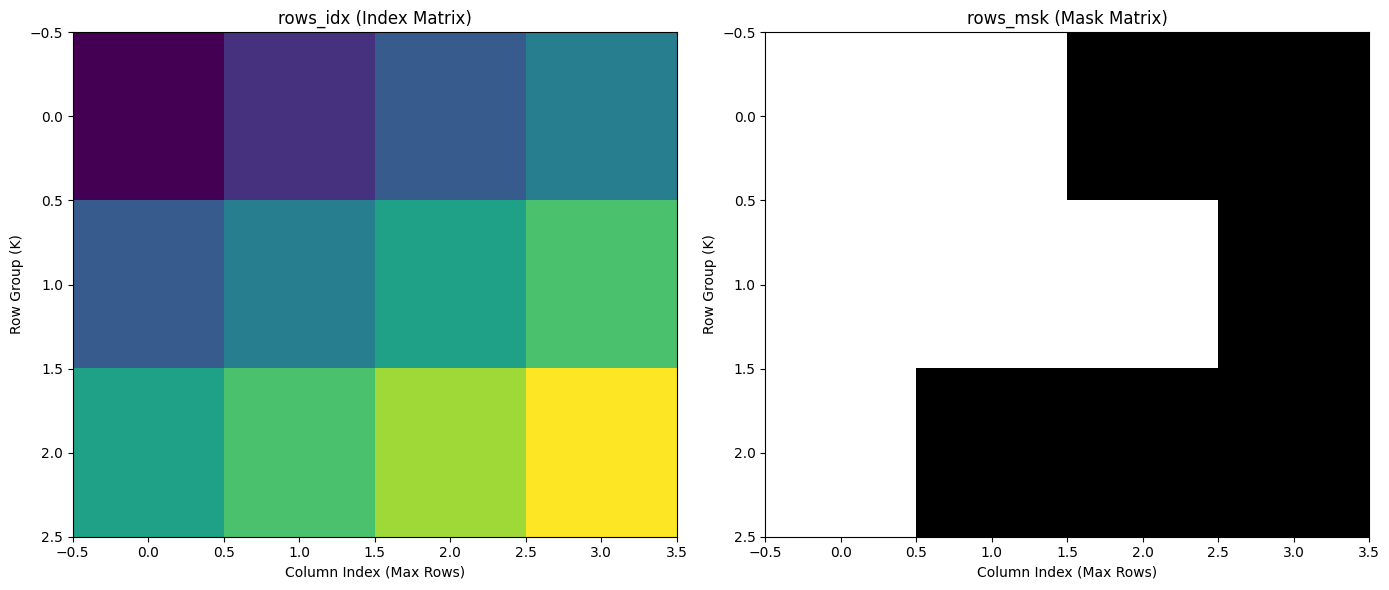

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Example values for parameters and layout, mimicking the provided code
row_off = np.array([0, 2, 4])  # (K,)
row_count = np.array([2, 3, 1])  # (K,)
max_rows = 4  # Example max rows (future-proof)

# Step 1: Compute rows_idx and rows_msk
rows_idx = row_off[:, None] + np.arange(max_rows)[None, :]  # (K, max_rows)
rows_msk = (np.arange(max_rows)[None, :] < row_count[:, None])  # (K, max_rows)

# Step 2: Plotting the result for better understanding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot rows_idx (indices matrix)
ax1.imshow(rows_idx, cmap='viridis', aspect='auto')
ax1.set_title("rows_idx (Index Matrix)")
ax1.set_xlabel("Column Index (Max Rows)")
ax1.set_ylabel("Row Group (K)")

# Plot rows_msk (mask matrix)
ax2.imshow(rows_msk, cmap='gray', aspect='auto')
ax2.set_title("rows_msk (Mask Matrix)")
ax2.set_xlabel("Column Index (Max Rows)")
ax2.set_ylabel("Row Group (K)")

plt.tight_layout()
plt.show()
